# Тесты с генетическим алгоритмом

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [13]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import random

import logging
logger = logging.getLogger('NRS')
logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [14]:
# from workFolder.nrs import q_out_simple


class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        self.pumps=[]
        self.hoses=[]
        self.inhoses=[]
        self.splitters=[]
        self.joiners=[]
        self.nozzles=[]
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)

        if isinstance(elmnt, GA_Element_Pump):
            self.pumps.append(elmnt)
            if elmnt.name=='': elmnt.name='Н'+str(self.counter)
        if isinstance(elmnt, GA_Element_Hose):
            self.hoses.append(elmnt)
            if elmnt.name=='': elmnt.name='НРЛ'+str(self.counter)
        if isinstance(elmnt, GA_Element_InHose):
            self.inhoses.append(elmnt)
            if elmnt.name=='': elmnt.name='ВРЛ'+str(self.counter)
        if isinstance(elmnt, GA_Element_Splitter):
            self.splitters.append(elmnt)
            if elmnt.name=='': elmnt.name='Р'+str(self.counter)
        if isinstance(elmnt, GA_Element_Joiner):
            self.joiners.append(elmnt)
            if elmnt.name=='': elmnt.name='ВС'+str(self.counter)
        if isinstance(elmnt, GA_Element_Nozzle):
            self.nozzles.append(elmnt)
            if elmnt.name=='': elmnt.name='Ств'+str(self.counter)
            
        return super().appendElement(elmnt)

    def crossing(self, pair_model):
        return self

    def mutate(self):
        return self

    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > H_max:
            self.H_add = H_max
        else:
            self.H_add = H_add
        if H_add <= H_min:
            self.H_add = H_min
        else:
            self.H_add = H_add

    def mutate(self):
        pass


class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([-1,1])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=3.7, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass




#====================================================================================================================================
# Вычисляем проводимость насадка для ствола Б
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleA = NRS_Revision.calc_p(7.4, 40)
p_nozzleL = NRS_Revision.calc_p(16, 40)

# Элементы
# pump = GA_Element_Pump('Насос', e_type=0, H_add=40)                                
# hoseW1 = GA_Element_Hose('РЛ1', e_type=1, s=NRS_Data.ss["51"], n=5)             
# nozzle1 = GA_Element_Nozzle('Ств1', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)
pump = GA_Element_Pump('', e_type=1, H_add=40)                                
hoseW1 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=5)             
nozzle1 = GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)

# Соединяем элементы
pump.append(hoseW1).append(nozzle1)

# Добавляем наблюдателей
watcher_pump = NRS_Observer_E(pump, ['q', 'H_add'])         # Для насоса. Наблюдаем изменения расхода и дополнительного напора (создаваемого насосом)
watcher_nozzle1 = NRS_Observer_E(nozzle1, ['q', 'H_in'])    # Для ствола. Наблюдаем изменения расхода и напора на входе

# Сборка модели
model = GA_model('Тест простой модели для ГА')
# model.build(pump, interpretate=True).observersInit()
# model.addElements([pump, hoseW1, nozzle1], interpretate=True).observersInit()
model.addElements([pump, hoseW1, nozzle1]).check_pumps().interpretate().observersInit()


# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

Новая модель: Тест простой модели для ГА
3.3423464007615813

Статус насоса:
H_add: 40
q: 3.3423464007615813


In [15]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  РРЛ1
  Ств2
in:
  Н0
out:
  Ств2


In [16]:
NRS_Revision.print_element_state(pump)

elements_next: [<__main__.GA_Element_Hose object at 0x00000279837A4290>]
elements_previous: []
type: 0
name: Н0
q: 3.3423464007615813
s: 0
H_in: 0
h: 0.0
z: 0
p: 1
n: 1
q_out: Ellipsis
H_add: 40
observer: <nrs.NRS_Observer_E object at 0x0000027984ED8050>
l: 0
ri: 2
ro: 2
H_out: 40.0


In [17]:
random.choice(list(NRS_Data.ss.keys()))

'250'

In [18]:
model.pumps

In [19]:
# hoseW2 = GA_Element_Hose('РРЛ2', e_type=1, s=NRS_Data.ss["77"], n=5)
hoseW2 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=5)

# Удаляем из ссылок текущего элемента ссылку на следующий элемент
next_e = hoseW1.elements_next[0]
del hoseW1.elements_next[0]
del next_e.elements_previous[0]
hoseW1.append(hoseW2).append(next_e)

# Пересобираем модель
# model.clear().build(hoseW1, interpretate=True).observersInit()
# model.build(hoseW1, interpretate=True).observersInit()
model.appendElement(hoseW2)
model.check_pumps().interpretate()   #.observersInit()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

3.294450493638155

Статус насоса:
H_add: 40
q: 3.294450493638155


In [20]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  РРЛ1
  Ств2
  РРЛ3
in:
  Н0
out:
  Ств2


In [21]:
pump2 = GA_Element_Pump('', e_type=1, H_add=40).addToModel(model)              
hoseM2 = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=10).addToModel(model)
pump2.append(hoseM2).append(pump)

# model.appendElement(hoseW2)
model.check_pumps().interpretate()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса 1:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])
print('Статус насоса 2:')
NRS_Revision.print_element_state(pump2, ['H_add', 'q'])

4.581690610099076

Статус насоса 1:
H_add: 40
q: 4.581690610099076
Статус насоса 2:
H_add: 40
q: 4.581690610099076


# Визуализация

Расстояние до Н0 200 м
Расстояние до Н4 400 м


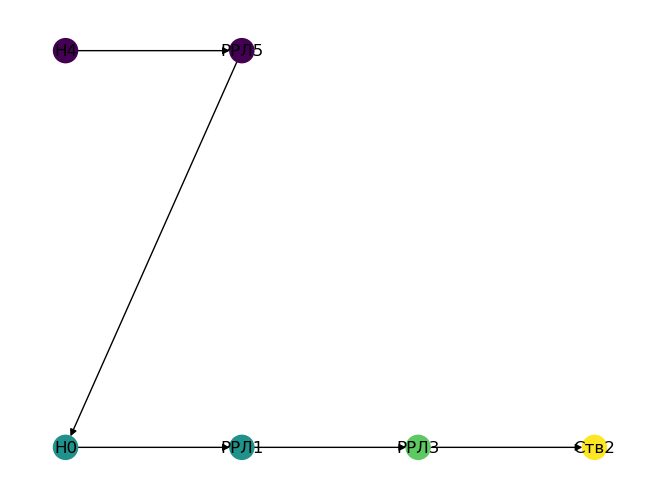

In [22]:
# model = model3
# Построение графа НРС
G = nx.DiGraph()
# Узлы - на каждый элемент
for elmnt in model.elmnts:
    G.add_node(elmnt.name, q=elmnt.q)
# Ребра - на каждую связь
for elmnt in model.elmnts:
    for elmnt_next in elmnt.elements_next:
        G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

# Расчет расстояния до элементов
# for elmnt in model.elmnts_out:
#     paths = nx.shortest_path_length(G, target = elmnt.name, weight='L')
#     nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
#     print(f'Расстояние до {elmnt.name} {max(paths.values())} м')
for elmnt in model.elmnts_in:
    paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
    nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
    print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

# Печать графа НРС
pos={}
pos_list=[]
level=0
for eo in model.elmnts_in:
    v = eo.name
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for nd, p in spl.items():
        if not nd in pos.keys():
            level_rize=level
            cpos = (p,level_rize)
            while cpos in pos_list:
                level_rize+=1
                cpos = (p,level_rize)
            pos[nd]=cpos
            pos_list.append(cpos)
    level+=1

# nc = [nd[1]['q'] for nd in list(G.nodes(data=True))]
nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
nx.draw(G, pos=pos, with_labels=True, node_color=nc)
plt.show()

In [10]:
list(G.nodes(data=True))

[('Н0', {'q': 3.294450493638155, 'L': 0}),
 ('РРЛ1', {'q': 3.294450493638155, 'L': 0}),
 ('Ств2', {'q': 3.294450493638155, 'L': 200}),
 ('РРЛ3', {'q': 3.294450493638155, 'L': 100})]

# Тесты

In [23]:
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleA = NRS_Revision.calc_p(7.4, 40)
p_nozzleL = NRS_Revision.calc_p(16, 40)

In [67]:
elements_sack = []
elements_sack.append(GA_Element_Pump('Н1', e_type=1, H_add=40))
elements_sack.append(GA_Element_Pump('Н2', e_type=0, H_add=60))
elements_sack.append(GA_Element_Pump('Н3', e_type=0, H_add=80))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=4))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=6))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=2))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=4))
elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=6))
elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle))
elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleA, q_out = q_out_nozzle))
elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleL, q_out = q_out_nozzle))
elements_sack.append(GA_Element_Joiner('', e_type=1, ri=2, ro=1))
elements_sack.append(GA_Element_Splitter('', e_type=1, ri=1, ro=3))

In [68]:
tmp_list = [e for e in elements_sack]

while len(tmp_list)>0:
    elmnt = tmp_list.pop(random.randrange(len(tmp_list)))
    # next_elmnt  = random.choice(elements_sack)
    elements_for_append = [e for e in elements_sack if e!=elmnt]
    elmnt.append(random.choice(elements_sack))

# Сборка модели
model = GA_model('Тест слепой часовщик')
# model.build(pump, interpretate=True).observersInit()
# model.addElements([pump, hoseW1, nozzle1], interpretate=True).observersInit()
model.addElements(elements_sack).check_pumps().interpretate()  #.observersInit()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

Новая модель: Тест слепой часовщик


OverflowError: complex exponentiation

In [69]:
NRS_Revision.print_model_elements(model)

all:
  Н1
  Н2
  Н3
  РРЛ3
  РРЛ4
  РРЛ5
  РРЛ6
  РРЛ7
  РРЛ8
  Ств9
  Ств10
  Ств11
  ВС12
  Р13
in:
  Н2
  Н3
out:
  Ств9
  Ств10
  Ств11


In [70]:
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

H_add: 40
q: 4.581690610099076


In [ ]:
print_NRS_graph(model)

In [ ]:
# def print_NRS_graph(model):
# Построение графа НРС
G = nx.DiGraph()
# Узлы - на каждый элемент
for elmnt in model.elmnts:
    G.add_node(elmnt.name, q=elmnt.q)
# Ребра - на каждую связь
for elmnt in model.elmnts:
    for elmnt_next in elmnt.elements_next:
        G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

# # Расчет расстояния до элементов
# for elmnt in model.elmnts_in:
#     paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
#     nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
#     print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

# Печать графа НРС
pos={}
pos_list=[]
level=0
for eo in model.elmnts_in:
    v = eo.name
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for nd, p in spl.items():
        if not nd in pos.keys():
            level_rize=level
            cpos = (p,level_rize)
            while cpos in pos_list:
                level_rize+=1
                cpos = (p,level_rize)
            pos[nd]=cpos
            pos_list.append(cpos)
    level+=1

# nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
nx.draw(G, pos=pos, with_labels=True)   #, node_color=nc)
plt.show()

In [60]:
pos

{'Н2': (0, 0)}

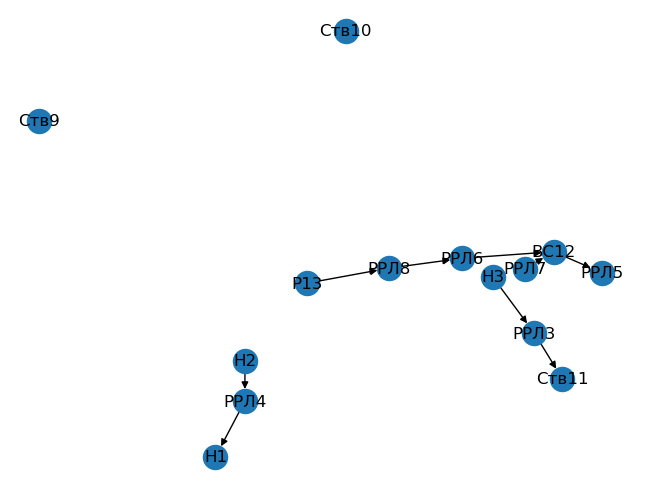

In [72]:
# Построение графа НРС
G = nx.DiGraph()
# Узлы - на каждый элемент
for elmnt in model.elmnts:
    G.add_node(elmnt.name, q=elmnt.q)
# Ребра - на каждую связь
for elmnt in model.elmnts:
    for elmnt_next in elmnt.elements_next:
        G.add_edge(elmnt.name, elmnt_next.name)

nx.draw(G, with_labels=True)
plt.show()